# Spatial Registration to Allen V3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import nrrd
import os

import anndata

from dredFISH.Utils import regu

# import importlib
# importlib.reload(regu)

In [2]:
%%time
# allen data
allen_template_path= '/greendata/binfo/mouse/Brain/average_template.npy'
allen_tree_path    = '/greendata/GeneralStorage/fangming/reference/allen_ccf/structures.json'
allen_annot_path   = '/greendata/GeneralStorage/fangming/reference/allen_ccf/annotation_10.nrrd'

allen_template = regu.load_allen_template(allen_template_path)
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)
allen_annot = regu.load_allen_annot(allen_annot_path) # takes about 30 seconds

CPU times: user 14.8 s, sys: 21.6 s, total: 36.4 s
Wall time: 36.4 s


In [3]:
# # plot alen average template front -> back
# rows = 10
# columns = 10
# fig, axs = plt.subplots(columns,rows,figsize=[25,22],)
# nbins = columns*rows
# bins = np.linspace(10,allen_template.shape[0]-10,nbins).astype(int)
# i = 0
# for ax in axs.ravel():
#     bin = bins[i]
#     img = allen_template[bin,:,:]
#     if img.max()==0:
#         continue
#     vmin,vmax=np.percentile(img[img>0].ravel(),[5,95])
#     ax.imshow(img,vmin=vmin,vmax=vmax,cmap='jet')
#     ax.set_title(bin)
#     ax.set_axis_off()
#     i+=1
# plt.subplots_adjust(wspace=0, 
#                     hspace=0.1)

In [4]:
# dredFISH data input
dataset   = 'DPNMF_PolyA_2021Nov19' # dataset tag
data_path = f'/greendata/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/results/raw_fishdata_Mar30.h5ad'

# ## output
version = 'v3'
outdir  = '/greendata/GeneralStorage/fangming/projects/dredfish/data_dump/'
reg_output_prefix = os.path.join(outdir, f"{dataset}_{version}_spatialreg_")
print(reg_output_prefix)
reg_force_overwrite = True

/greendata/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v3_spatialreg_


In [5]:
df = anndata.read(data_path, backed='r').obs
XY = df[['stage_x', 'stage_y']].values
XY

array([[-2413.58650925,  3496.71287912],
       [-2412.2924244 ,  3443.82125943],
       [-2413.86476218,  3264.86541089],
       ...,
       [ -414.58005688,  3313.17069568],
       [ -415.74334204,  3335.268     ],
       [ -415.90045239,  3345.51451587]])

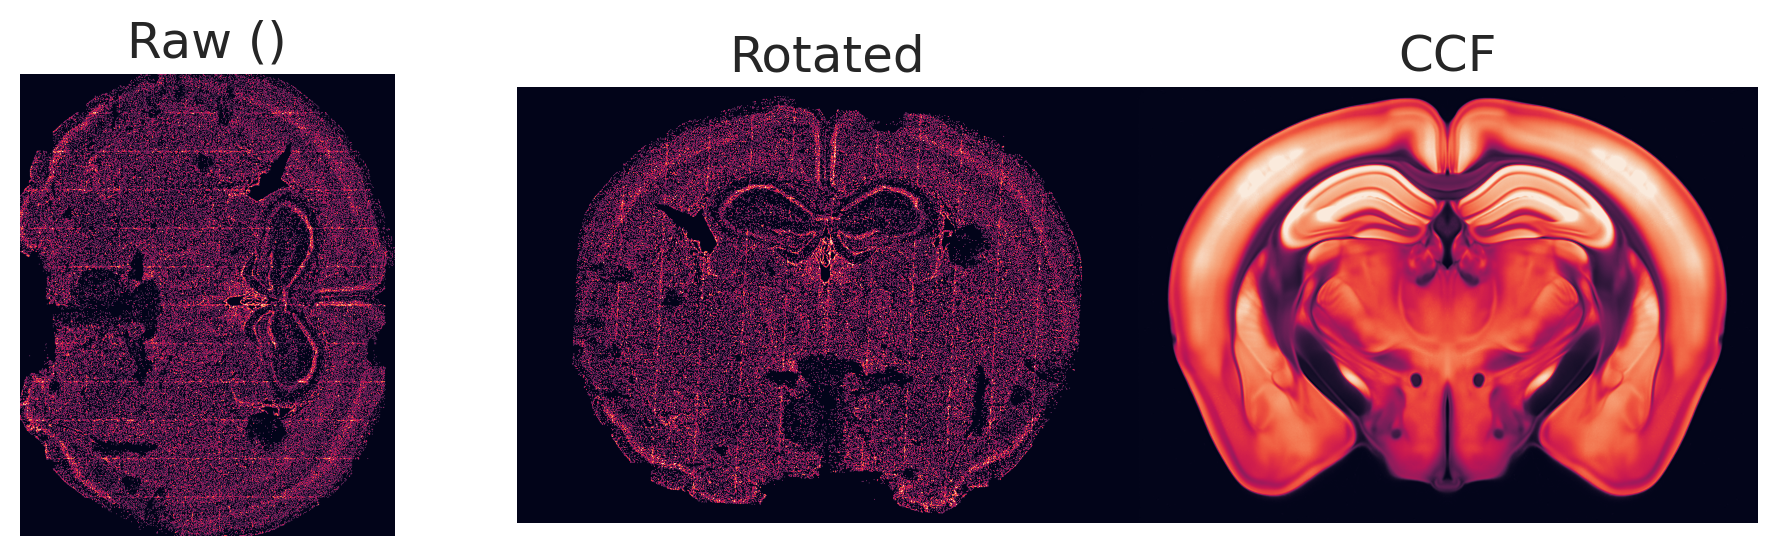

In [6]:
reg_idx  = 720 # 916
reg_flip = False # True
regu.check_run(XY, 
                allen_template, 
                allen_annot, 
                allen_maps,
                reg_idx, 
                flip=reg_flip)

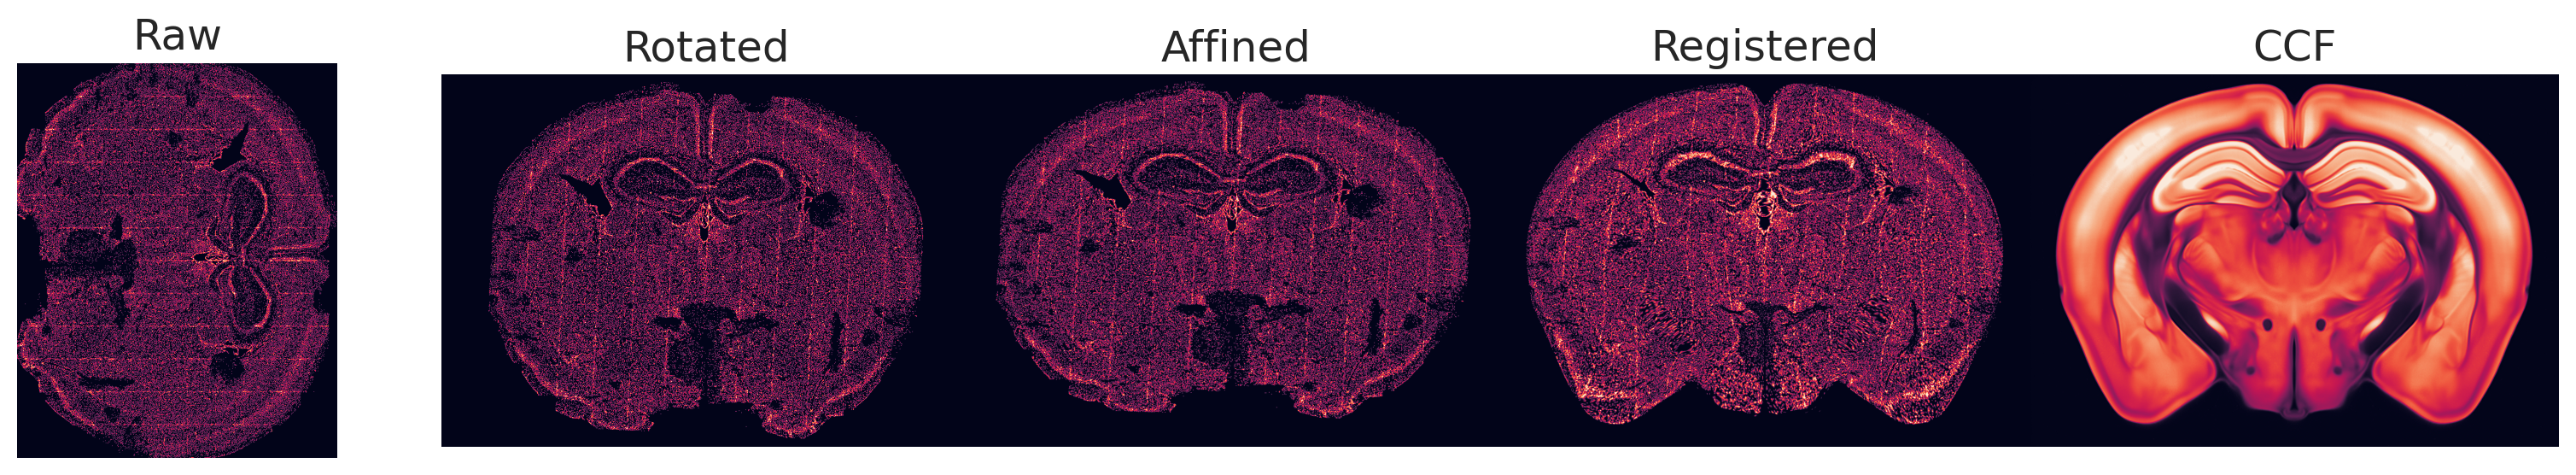

saved to /greendata/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v3_spatialreg_registered.hdf5


In [7]:
spatial_data = regu.real_run(XY, 
                            allen_template, 
                            allen_annot, 
                            allen_maps,
                            reg_idx, 
                            flip=reg_flip,
                            name="", 
                            outprefix=reg_output_prefix, # CHECK THIS
                            force=reg_force_overwrite,
                            )
# update results to anndata (cell level atrributes)
df_res = pd.DataFrame()
df_res['coord_x']        = np.array(spatial_data.points_rot[:,0])
df_res['coord_y']        = np.array(spatial_data.points_rot[:,1])
df_res['region_id']      = np.array(spatial_data.region_id)
df_res['region_color']   = np.array(spatial_data.region_color) 
df_res['region_acronym'] = np.array(spatial_data.region_acronym)
# self.save_data()

In [8]:
df_res

coord_x      coord_y  region_id region_color region_acronym
0       3066.632792   582.574703        574      #98D6F9             CP
1       3013.860099   578.800986        574      #98D6F9             CP
2       2835.027489   571.977073       1218      #CCCCCC             ar
3       2784.899438   570.399427       1218      #CCCCCC             ar
4       2773.655749   566.644009       1218      #CCCCCC             ar
...             ...          ...        ...          ...            ...
113753  2962.233204 -1423.737878         57      #188064      SSp-bfd6a
113754  2790.109448 -1432.947971       1200      #CCCCCC            ccs
113755  2977.062698 -1422.840896         57      #188064      SSp-bfd6a
113756  2999.081110 -1420.642344         57      #188064      SSp-bfd6a
113757  3009.308977 -1420.004760         57      #188064      SSp-bfd6a

[113758 rows x 5 columns]

In [9]:
# check results -- plot all cells
def plot_spatial(df_res):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.scatter(df_res['coord_x'], 
               df_res['coord_y'],
               c=df_res['region_color'],
               s=0.05,
               rasterized=True,
              )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title('Cells colored by brain regions (moved ABA)')
    ax.axis('off')
    plt.show()

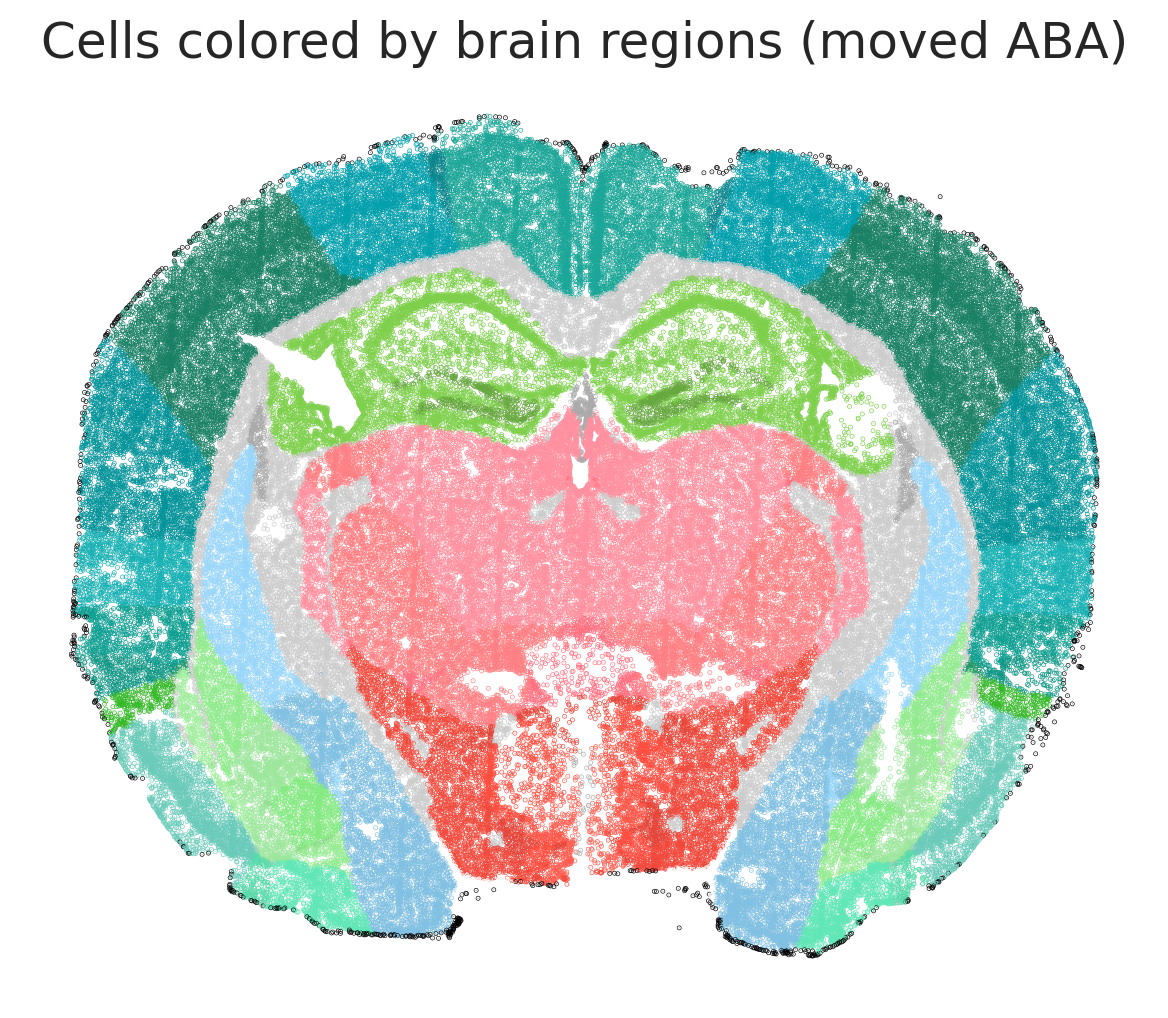

In [10]:
plot_spatial(df_res)